In [1]:
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)

Get Team ID's for all NBA teams

In [3]:
from nba_api.stats.static import teams
# get_teams returns a list of 30 dictionaries, each an NBA team.
nba_teams = pd.DataFrame(teams.get_teams())
#print('Number of teams fetched: {}'.format(len(nba_teams)))
#nba_teams

#create a list of all ids
team_ids = nba_teams['id'].tolist()
print(team_ids)

[1610612737, 1610612738, 1610612739, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766]


Create a nested list of all team ID's and last 5 seasons that will be used in for loop api call.

In [4]:
import itertools
season = ['2021-22'] #,'2020-21','2019-20','2018-19','2017-18']
#create a list of all permutations of team_ids and season
team_season = list(itertools.product(team_ids, season))



Call nba_api for all teams for the given seasons based on previous list that was created

In [5]:
from nba_api.stats.endpoints import leaguegamefinder
NBA_seasons = pd.DataFrame()
#get all games for team_ids
for i in team_season:
    t, s = i
    games = leaguegamefinder.LeagueGameFinder(team_id_nullable = t,season_nullable = s,season_type_nullable ='Regular Season').get_data_frames()[0]
    NBA_seasons = NBA_seasons.append(games, ignore_index=True)

/var/folders/71/8rtftxrj1njcvdvj90ttmthc0000gn/T/ipykernel_2976/942571498.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NBA_seasons = NBA_seasons.append(games, ignore_index=True)
/var/folders/71/8rtftxrj1njcvdvj90ttmthc0000gn/T/ipykernel_2976/942571498.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NBA_seasons = NBA_seasons.append(games, ignore_index=True)
/var/folders/71/8rtftxrj1njcvdvj90ttmthc0000gn/T/ipykernel_2976/942571498.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  NBA_seasons = NBA_seasons.append(games, ignore_index=True)
/var/folders/71/8rtftxrj1njcvdvj90ttmthc0000gn/T/ipykernel_2976/942571498.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

Get team stats for specific team

In [9]:
# subset TEAM_ABBREVIATION = 'DAL'
NBA_seasons_DAL = NBA_seasons[NBA_seasons.MATCHUP.str.contains('DAL')]

In [10]:
#function to combine matchup data
def combine_team_games(df, keep_method='home'):
    '''Combine a TEAM_ID-GAME_ID unique table into rows by game. Slow.

        Parameters
        ----------
        df : Input DataFrame.
        keep_method : {'home', 'away', 'winner', 'loser', ``None``}, default 'home'
            - 'home' : Keep rows where TEAM_A is the home team.
            - 'away' : Keep rows where TEAM_A is the away team.
            - 'winner' : Keep rows where TEAM_A is the losing team.
            - 'loser' : Keep rows where TEAM_A is the winning team.
            - ``None`` : Keep all rows. Will result in an output DataFrame the same
                length as the input DataFrame.
                
        Returns
        -------
        result : DataFrame
    '''
    # Join every row to all others with the same game ID.
    joined = pd.merge(df, df, suffixes=['_A', '_B'],
                      on=['SEASON_ID', 'GAME_ID', 'GAME_DATE'])
    # Filter out any row that is joined to itself.
    result = joined[joined.TEAM_ID_A != joined.TEAM_ID_B]
    # Take action based on the keep_method flag.
    if keep_method is None:
        # Return all the rows.
        pass
    elif keep_method.lower() == 'home':
        # Keep rows where TEAM_A is the home team.
        result = result[result.MATCHUP_A.str.contains(' vs. ')]
    elif keep_method.lower() == 'away':
        # Keep rows where TEAM_A is the away team.
        result = result[result.MATCHUP_A.str.contains(' @ ')]
    elif keep_method.lower() == 'winner':
        result = result[result.WL_A == 'W']
    elif keep_method.lower() == 'loser':
        result = result[result.WL_A == 'L']
    else:
        raise ValueError(f'Invalid keep_method: {keep_method}')
    return result
    


In [11]:
# Combine the game rows into one. By default, the home team will be TEAM_A.
game_df = combine_team_games(NBA_seasons_DAL)
game_df.head()

,SEASON_ID,TEAM_ID_A,TEAM_ABBREVIATION_A,TEAM_NAME_A,GAME_ID,GAME_DATE,MATCHUP_A,WL_A,MIN_A,PTS_A,FGM_A,FGA_A,FG_PCT_A,FG3M_A,FG3A_A,FG3_PCT_A,FTM_A,FTA_A,FT_PCT_A,OREB_A,DREB_A,REB_A,AST_A,STL_A,BLK_A,TOV_A,PF_A,PLUS_MINUS_A,TEAM_ID_B,TEAM_ABBREVIATION_B,TEAM_NAME_B,MATCHUP_B,WL_B,MIN_B,PTS_B,FGM_B,FGA_B,FG_PCT_B,FG3M_B,FG3A_B,FG3_PCT_B,FTM_B,FTA_B,FT_PCT_B,OREB_B,DREB_B,REB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B,PLUS_MINUS_B
2,22021,1610612742,DAL,Dallas Mavericks,0022100807,2022-02-06,DAL vs. ATL,W,239,103,38,88,0.432,16,36,0.444,11,13,0.846,12,36,48,25,8,5,14,25,9.0,1610612737,ATL,Atlanta Hawks,ATL @ DAL,L,240,94,37,95,0.389,5,25,0.200,15,16,0.938,15,35,50,21,7,4,12,18,-9.0
5,22021,1610612737,ATL,Atlanta Hawks,0022100014,2021-10-21,ATL vs. DAL,W,242,113,45,94,0.479,15,35,0.429,8,9,0.889,6,49,55,31,8,9,13,16,26.0,1610612742,DAL,Dallas Mavericks,DAL @ ATL,L,240,87,31,93,0.333,13,43,0.302,12,13,0.923,10,40,50,16,7,3,15,21,-26.0
9,22021,1610612738,BOS,Boston Celtics,0022101014,2022-03-13,BOS vs. DAL,L,239,92,33,88,0.375,9,37,0.243,17,19,0.895,11,34,45,16,8,3,11,12,-3.0,1610612742,DAL,Dallas Mavericks,DAL @ BOS,W,241,95,33,74,0.446,15,37,0.405,14,19,0.737,4,38,42,20,7,5,17,16,3.0
14,22021,1610612742,DAL,Dallas Mavericks,0022100136,2021-11-06,DAL vs. BOS,W,241,107,41,78,0.526,13,39,0.333,12,14,0.857,7,33,40,19,7,6,15,18,3.0,1610612738,BOS,Boston Celtics,BOS @ DAL,L,240,104,42,86,0.488,9,31,0.290,11,16,0.688,8,28,36,20,6,2,11,14,-3.0
17,22021,1610612739,CLE,Cleveland Cavaliers,0022101136,2022-03-30,CLE vs. DAL,L,240,112,42,83,0.506,11,25,0.440,17,22,0.773,9,30,39,24,7,3,13,15,-8.0,1610612742,DAL,Dallas Mavericks,DAL @ CLE,W,241,120,46,88,0.523,16,42,0.381,12,15,0.800,9,29,38,28,6,6,11,17,8.0


<AxesSubplot:xlabel='TEAM_ABBREVIATION'>

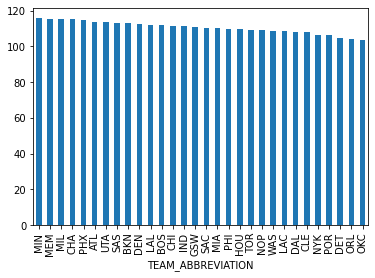

In [6]:
#plot mean points per game for each team abbreviation ascending by PTS
NBA_seasons.groupby('TEAM_ABBREVIATION').mean()['PTS'].sort_values(ascending=False).plot(kind='bar')
#NBA_seasons.groupby('TEAM_ABBREVIATION').PTS.mean().plot(kind='bar')


<AxesSubplot:xlabel='GAME_DATE'>

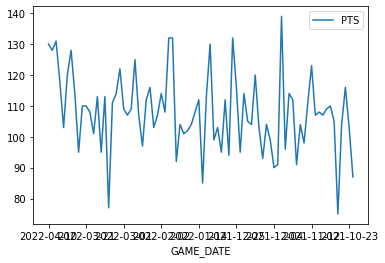

In [7]:
#filter Team_Abbreviation by DAL and plot PTS over time
NBA_seasons.loc[NBA_seasons['TEAM_ABBREVIATION'] == 'DAL'].plot(x='GAME_DATE', y='PTS', kind='line')
#NBA_seasons.groupby('SEASON_ID').PTS.plot(kind='line')
#NBA_seasons.groupby('GAME_DATE').PTS.mean().plot(kind='line')